In [37]:
import scipy.cluster.hierarchy as sch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import sklearn

In [13]:
#建立與 MySQL 的連結
class mysql_engine():
 def __init__(self,db):
  self.user='root'
  self.passwd='ian1991'
  self.host='localhost'
  self.port = '3306'
  self.db_name= db
  self.engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}?charset=utf8'.format(self.user,self.passwd,self.host,self.port,self.db_name))

def get_data(sql,db):
 pg_enine = mysql_engine(db)
 try:
  with pg_enine.engine.connect() as con, con.begin():
   df = pd.read_sql(sql,con) # 獲取資料
  con.close()
 except:
  df = None
 return df

In [189]:
#取得需要的特徵:營收成長率, 稅後淨利率, 營業毛利率, 股東權益報酬率, 資產報酬率
company_factor = get_data("""SELECT stock_code,
                                    stock_report_date data_date,
                                    revenue_growth_rate,
                                    net_profit_rate,
                                    operating_gross_rate,
                                    roe_rate, 
                                    roa_rate
                             FROM finacial_statements;""",'stock')
company_factor

,stock_code,data_date,revenue_growth_rate,net_profit_rate,operating_gross_rate,roe_rate,roa_rate
0,2302,20161,8.84,6.95,27.00,0.51,0.46
1,2302,20162,6.59,7.03,32.37,0.56,0.50
2,2302,20163,-4.58,-1.81,26.56,-0.14,-0.09
3,2302,20164,-4.79,-1.82,35.05,-0.13,-0.07
4,2302,20171,-18.19,-16.30,32.74,-1.03,-0.78
...,...,...,...,...,...,...,...
3493,8299,20202,10.95,10.91,24.76,4.01,2.97
3494,8299,20203,-3.71,15.41,22.61,6.07,4.61
3495,8299,20204,-2.52,29.47,23.05,11.76,8.79
3496,8299,20211,0.17,13.09,29.71,4.71,3.41


In [187]:
#建立負債比率變動率計算 function
def debt_rate_change(series):
    ans = []
    for i in range(len(series)):
        try:
            tmp = round(((series[i] - series[i-1])/series[i-1]),2)
            ans.append(tmp)
        except:
            tmp = None
            ans.append(tmp)
    return ans  

In [188]:
#建立負債比率變動率
companys =['2330','2303','2329','2330','2337','2338','2342','2344','2351','2363',
            '2369','2379','2388','2401','2408','2434','2436','2441','2449','2451',
            '2454','2458','2481','3006','3014','3016','3034','3035','3041','3054',
            '3094','3189','3257','3413','3443','3450','3530','3532','3536','3545',
            '3583','3588','3661','3686','3711','4919','4952','4961','4967','4968',
            '5222','5269','5285','5471','6202','6239','6243','6257','6271','6415',
            '6451','6515','6525','6531','6533','6552','6573','6756','8016','8028',
            '8081','8110','8131','8150','8261','8271','3073','3105','3122','3141',
            '3169','3227','3228','3259','3260','3264','3265','3268','3317','3372',
            '3374','3438','3527','3529','3555','3556','3567','3581','3675','3680',
            '3707','4945','4966','4971','4973','4991','5236','5272','5274','5299',
            '5302','5314','5344','5347','5351','5425','5468','5483','5487','6104',
            '6129','6138','6147','6182','6198','6223','6233','6237','6261','8299',
            '6287','6291','6411','6435','6457','6462','6485','6488','6494','6510',
            '6532','6548','6568','6594','6640','6643','6651','6679','6683','6684',
            '6716','6732','6788','7556','8024','8040','8054','8086','8088','8277',
             ]
df_dr_change = pd.DataFrame([],columns=['stock_code','data_date','debt_rate','debt_rate_change'])
i = 0
for company in companys:
    debt_rate_factor = get_data(f"""SELECT stock_code,
                                           stock_report_date data_date,
                                           debt_rate
                                     FROM finacial_statements
                                     WHERE stock_code = {company};""",'stock')  #負債比率
    debt_rate_factor.insert(3,"debt_rate_change",debt_rate_change(debt_rate_factor['debt_rate'])) #計算並插入負債變動率

    try:
        df_dr_change = df_dr_change.append(debt_rate_factor, ignore_index = True)
        i += 1
    except:
        print(company," ERROR!!")
        
print("total companys = ",i)
df_dr_change

total companys =  160


,stock_code,data_date,debt_rate,debt_rate_change
0,2330,20161,25.81,NaN
1,2330,20162,33.65,0.30
2,2330,20163,25.30,-0.25
3,2330,20164,26.31,0.04
4,2330,20171,24.73,-0.06
...,...,...,...,...
3471,8277,20202,5.35,-0.11
3472,8277,20203,13.68,1.56
3473,8277,20204,13.72,0.00
3474,8277,20211,11.57,-0.16


In [198]:
data_df = pd.merge(company_factor, df_dr_change, on=["data_date",'stock_code'], how="inner")
data_df

,stock_code,data_date,revenue_growth_rate,net_profit_rate,operating_gross_rate,roe_rate,roa_rate,debt_rate,debt_rate_change
0,2303,20161,-8.62,0.23,14.63,0.03,0.16,33.77,NaN
1,2303,20162,-2.67,4.27,22.39,0.70,0.51,40.29,0.19
2,2303,20163,8.05,4.60,21.75,0.78,0.59,41.59,0.03
3,2303,20164,13.17,1.17,22.87,0.20,0.19,43.43,0.04
4,2303,20171,8.76,4.00,19.85,0.69,0.60,42.89,-0.01
...,...,...,...,...,...,...,...,...,...
3471,8299,20202,10.95,10.91,24.76,4.01,2.97,27.74,0.08
3472,8299,20203,-3.71,15.41,22.61,6.07,4.61,23.66,-0.15
3473,8299,20204,-2.52,29.47,23.05,11.76,8.79,26.09,0.10
3474,8299,20211,0.17,13.09,29.71,4.71,3.41,29.32,0.12


In [199]:
data_df.isnull().sum()

stock_code                0
data_date                 0
revenue_growth_rate     286
net_profit_rate         201
operating_gross_rate    200
roe_rate                201
roa_rate                202
debt_rate               145
debt_rate_change        339
dtype: int64

In [245]:
#缺值處理
financial_ratio_nona = data_df.copy()

#刪除
financial_ratio_nona = financial_ratio_nona.dropna()

In [201]:
financial_ratio_nona.isnull().sum()

stock_code              0
data_date               0
revenue_growth_rate     0
net_profit_rate         0
operating_gross_rate    0
roe_rate                0
roa_rate                0
debt_rate               0
debt_rate_change        0
dtype: int64

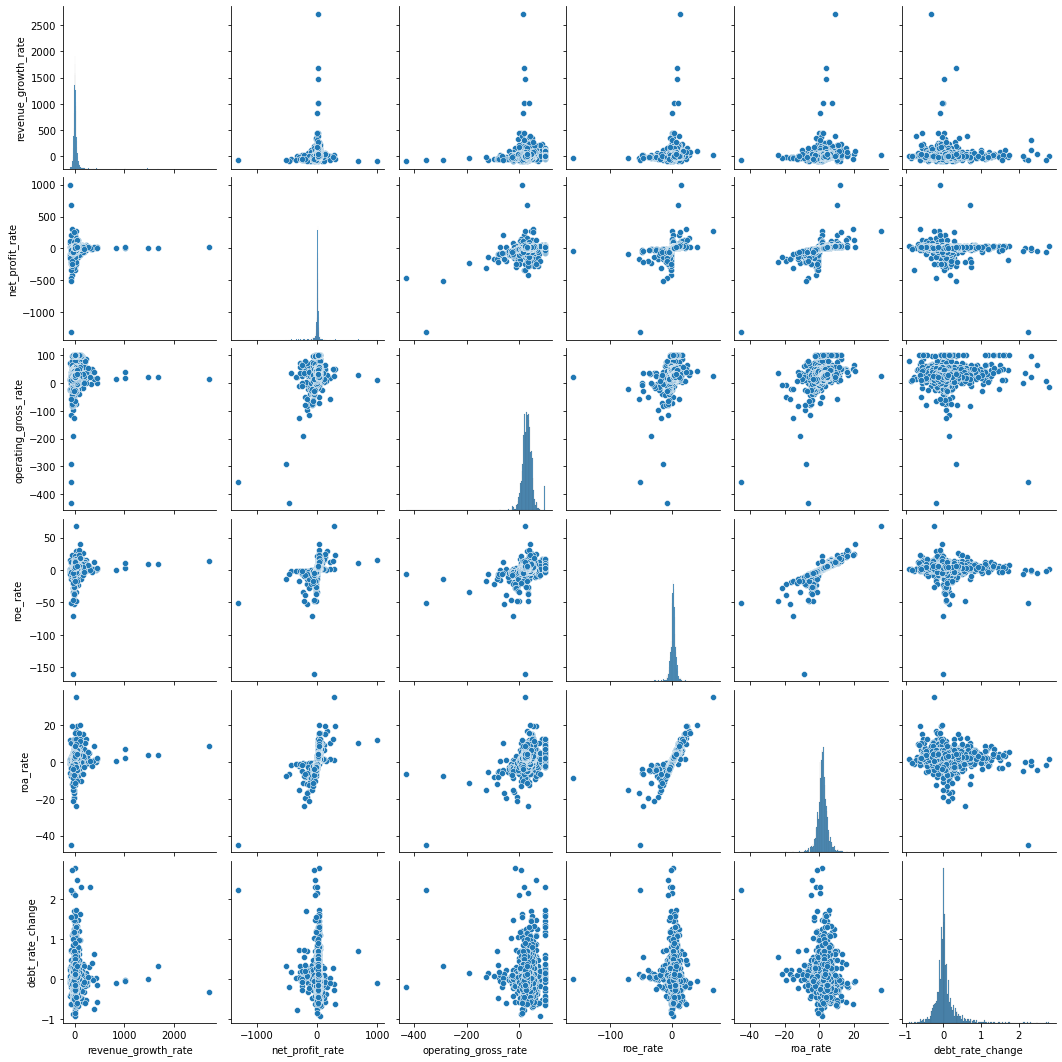

In [83]:
#觀察資料間的關係
compare_df = financial_ratio_nona.drop(['stock_code','data_date','debt_rate'], axis=1)
sns.pairplot(compare_df)

In [270]:
X0 = financial_ratio_nona[['revenue_growth_rate','net_profit_rate','operating_gross_rate']] #營收成長率、淨利率、毛利率
X1 = financial_ratio_nona[['revenue_growth_rate','roe_rate','roa_rate']] #營收成長率、ROA、ROE
X2 = financial_ratio_nona[['revenue_growth_rate','debt_rate_change','roa_rate']] #營收成長率、負債變動率、ROA
X3 = financial_ratio_nona[['operating_gross_rate','debt_rate_change','roa_rate']] #毛利率、負債變動率、ROA
X_all = financial_ratio_nona[['revenue_growth_rate','net_profit_rate','operating_gross_rate','roe_rate', 'roa_rate','debt_rate_change']]
X_all.iloc[:,0]

1       -2.67
2        8.05
3       13.17
4        8.76
5        1.46
        ...  
3471    10.95
3472    -3.71
3473    -2.52
3474     0.17
3475    46.57
Name: revenue_growth_rate, Length: 3054, dtype: float64

In [273]:
# 輸入數據調成標準值以免各特徵影響不同
# you'll learn why scaling is needed in a later course
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled0 = scaler.fit_transform(X0)
X_scaled1 = scaler.fit_transform(X1)
X_scaled2 = scaler.fit_transform(X2)
X_scaled3 = scaler.fit_transform(X3)
X_scaled_all = scaler.fit_transform(X_all)
print(X_scaled_all.max())
print(X_scaled_all.min())
X_scaled_all.std()

33.39636407278067
-26.222632456295155


1.0

In [60]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

In [239]:
#建立 DBSCAN 模型
dbscan0 = DBSCAN(eps=0.65, min_samples = 6)
dbscan0.fit(X_scaled0)
dbscan1 = DBSCAN(eps=0.65, min_samples = 6)
dbscan1.fit(X_scaled1)
dbscan2 = DBSCAN(eps=0.65, min_samples = 6)
dbscan2.fit(X_scaled2)
dbscan3 = DBSCAN(eps=0.8, min_samples = 8)
dbscan3.fit(X_scaled3)
dbscan_all = DBSCAN(eps=0.5, min_samples = 6)
dbscan_all.fit(X_scaled_all)

DBSCAN(min_samples=6)

In [240]:
#檢視分群群數
print(set(dbscan0.labels_))
print(set(dbscan1.labels_))
print(set(dbscan2.labels_))
print(set(dbscan3.labels_))
print(set(dbscan_all.labels_))

{0, 1, -1}
{0, 1, -1}
{0, 1, -1}
{0, 1, -1}
{0, 1, -1}


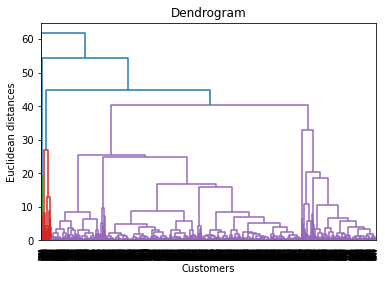

In [80]:
dendrogram0 = sch.dendrogram(sch.linkage(X_scaled0, method  = "ward"))
plt.rcParams["figure.figsize"] = (16, 16)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

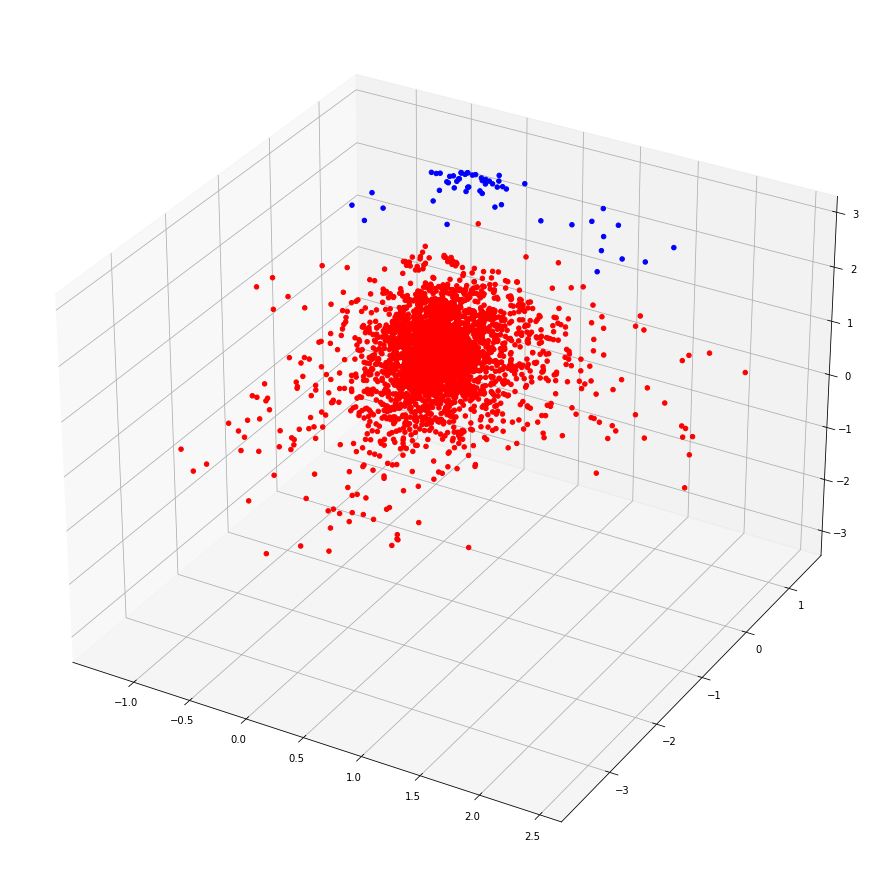

In [142]:
fig0 = plt.figure()
ax4 = plt.axes(projection='3d')
ax4.scatter(X_scaled0[dbscan0.labels_==0, 0],X_scaled0[dbscan0.labels_==0, 1],X_scaled0[dbscan0.labels_==0, 2],alpha=1,c="red")
# ax4.scatter(X_scaled0[dbscan0.labels_==-1, 0],X_scaled0[dbscan0.labels_==-1, 1],X_scaled0[dbscan0.labels_==-1, 2],alpha=1,c="green")
ax4.scatter(X_scaled0[dbscan0.labels_==1, 0],X_scaled0[dbscan0.labels_==1, 1],X_scaled0[dbscan0.labels_==1, 2],alpha=1,c="blue")
ax4.scatter(X_scaled0[dbscan0.labels_==2, 0],X_scaled0[dbscan0.labels_==2, 1],X_scaled0[dbscan0.labels_==2, 2],alpha=1,c="yellow")
plt.show()

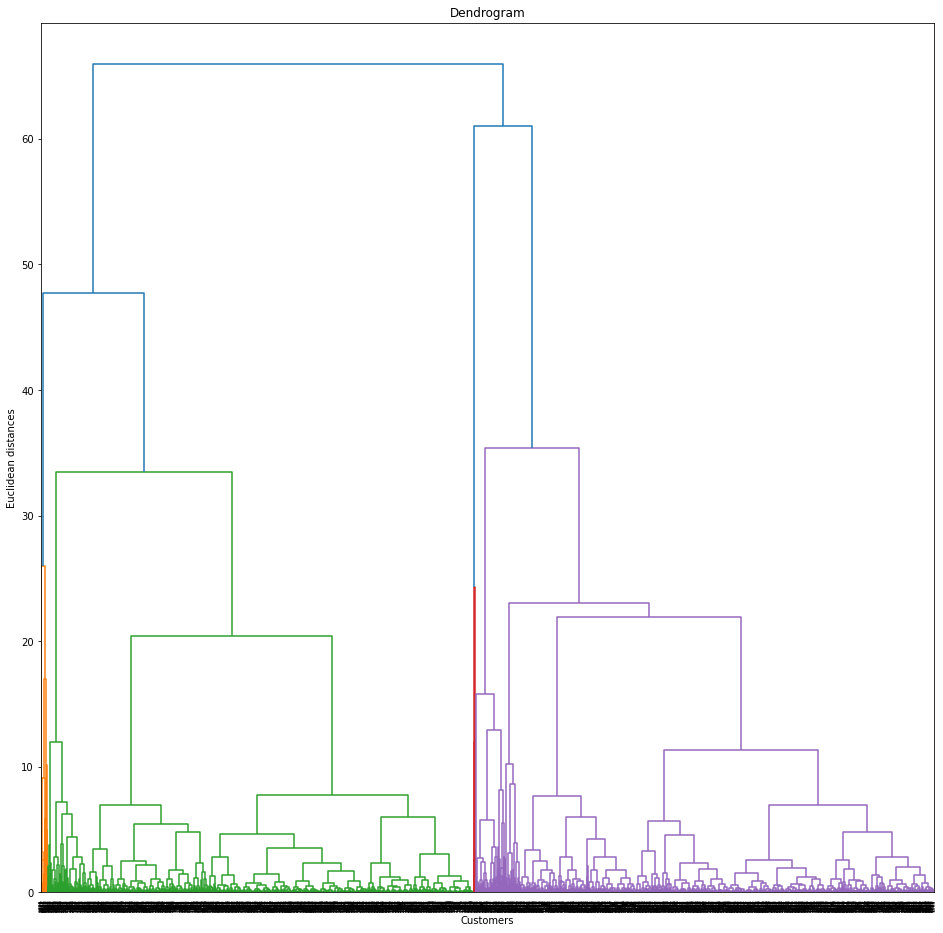

In [114]:
dendrogram1 = sch.dendrogram(sch.linkage(X_scaled1, method  = "ward"))
plt.rcParams["figure.figsize"] = (16, 16)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

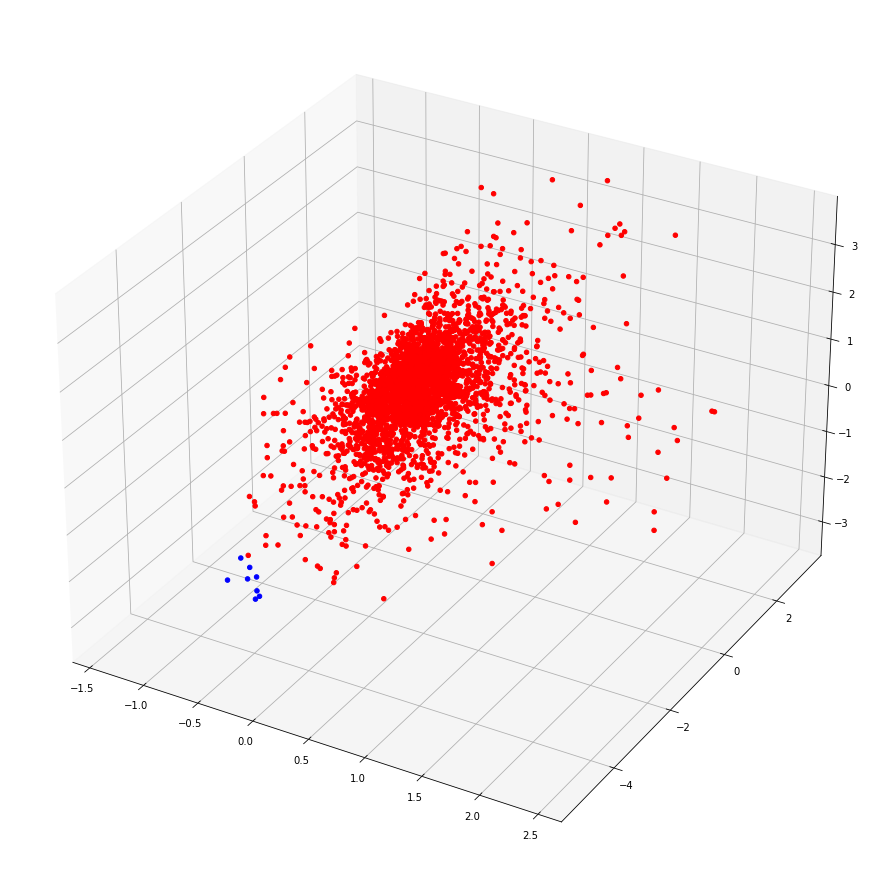

In [145]:
fig1 = plt.figure()
ax4 = plt.axes(projection='3d')
ax4.scatter(X_scaled1[dbscan1.labels_==0, 0],X_scaled1[dbscan1.labels_==0, 1],X_scaled1[dbscan1.labels_==0, 2],alpha=1,c="red")
# ax4.scatter(X_scaled1[dbscan1.labels_==-1, 0],X_scaled1[dbscan1.labels_==-1, 1],X_scaled1[dbscan1.labels_==-1, 2],alpha=1,c="green")
ax4.scatter(X_scaled1[dbscan1.labels_==1, 0],X_scaled1[dbscan1.labels_==1, 1],X_scaled1[dbscan1.labels_==1, 2],alpha=1,c="blue")
ax4.scatter(X_scaled1[dbscan1.labels_==2, 0],X_scaled1[dbscan1.labels_==2, 1],X_scaled1[dbscan1.labels_==2, 2],alpha=1,c="yellow")
plt.show()

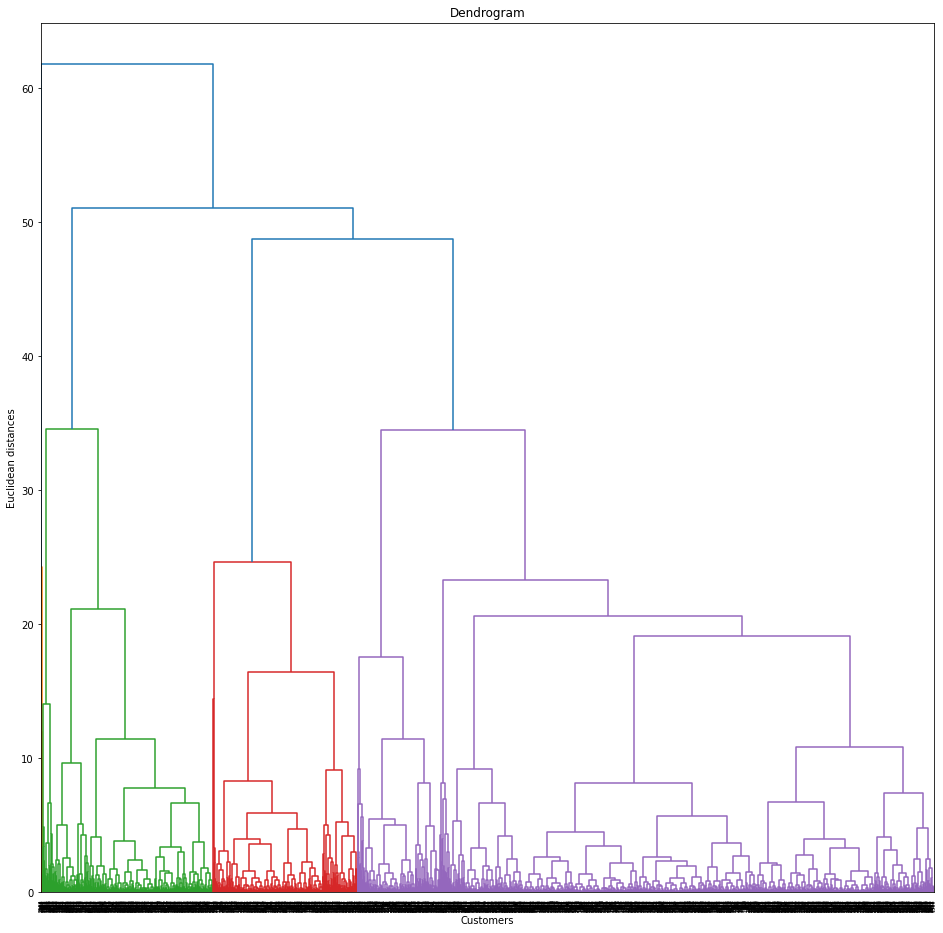

In [82]:
dendrogram2 = sch.dendrogram(sch.linkage(X_scaled2, method  = "ward"))
plt.rcParams["figure.figsize"] = (16, 16)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

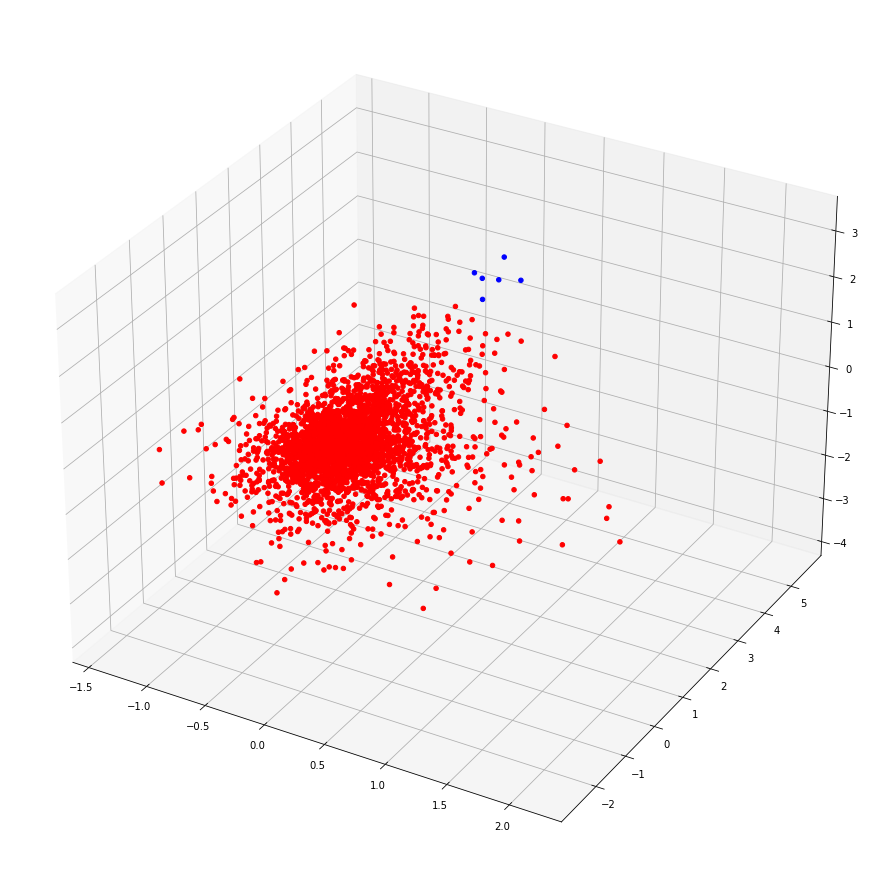

In [146]:
fig2 = plt.figure()
ax4 = plt.axes(projection='3d')
ax4.scatter(X_scaled2[dbscan2.labels_==0, 0],X_scaled2[dbscan2.labels_==0, 1],X_scaled2[dbscan2.labels_==0, 2],alpha=1,c="red")
# ax4.scatter(X_scaled2[dbscan2.labels_==-1, 0],X_scaled2[dbscan2.labels_==-1, 1],X_scaled2[dbscan2.labels_==-1, 2],alpha=1,c="green")
ax4.scatter(X_scaled2[dbscan2.labels_==1, 0],X_scaled2[dbscan2.labels_==1, 1],X_scaled2[dbscan2.labels_==1, 2],alpha=1,c="blue")
ax4.scatter(X_scaled2[dbscan2.labels_==2, 0],X_scaled2[dbscan2.labels_==2, 1],X_scaled2[dbscan2.labels_==2, 2],alpha=1,c="yellow")
ax4.scatter(X_scaled2[dbscan2.labels_==3, 0],X_scaled2[dbscan2.labels_==3, 1],X_scaled2[dbscan2.labels_==3, 2],alpha=1,c="orange")
plt.show()

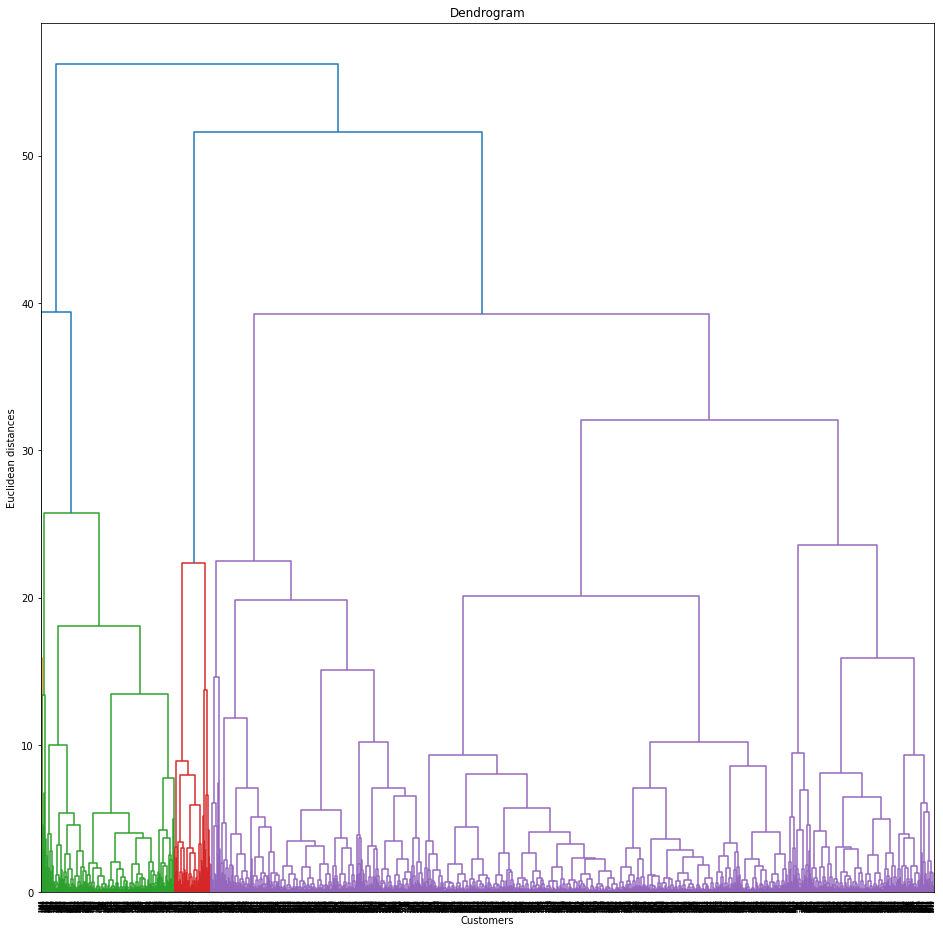

In [92]:
dendrogram3 = sch.dendrogram(sch.linkage(X_scaled3, method  = "ward"))
plt.rcParams["figure.figsize"] = (16, 16)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

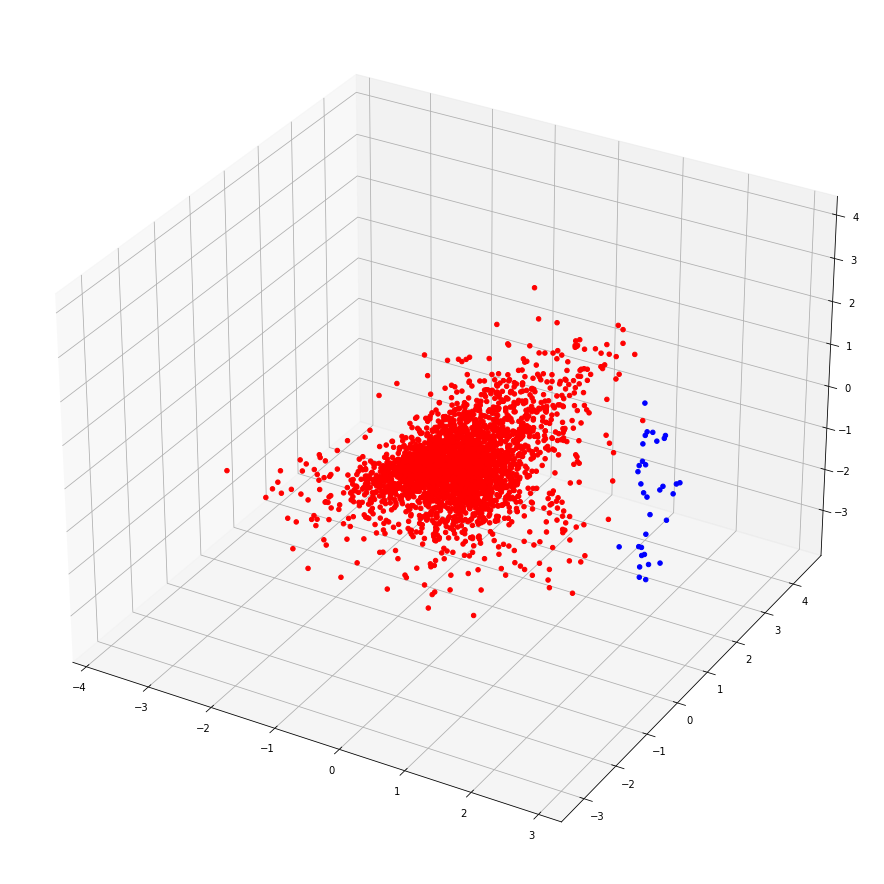

In [182]:
fig3 = plt.figure()
ax4 = plt.axes(projection='3d')
ax4.scatter(X_scaled3[dbscan3.labels_==0, 0],X_scaled3[dbscan3.labels_==0, 1],X_scaled3[dbscan3.labels_==0, 2],alpha=1,c="red")
# ax4.scatter(X_scaled3[dbscan3.labels_==-1, 0],X_scaled3[dbscan3.labels_==-1, 1],X_scaled3[dbscan3.labels_==-1, 2],alpha=1,c="green")
ax4.scatter(X_scaled3[dbscan3.labels_==1, 0],X_scaled3[dbscan3.labels_==1, 1],X_scaled3[dbscan3.labels_==1, 2],alpha=1,c="blue")
ax4.scatter(X_scaled3[dbscan3.labels_==2, 0],X_scaled3[dbscan3.labels_==2, 1],X_scaled3[dbscan3.labels_==2, 2],alpha=1,c="yellow")
ax4.scatter(X_scaled3[dbscan3.labels_==3, 0],X_scaled3[dbscan3.labels_==3, 1],X_scaled3[dbscan3.labels_==3, 2],alpha=1,c="purple")
ax4.scatter(X_scaled3[dbscan3.labels_==4, 0],X_scaled3[dbscan3.labels_==4, 1],X_scaled3[dbscan3.labels_==4, 2],alpha=1,c="orange")
ax4.scatter(X_scaled3[dbscan3.labels_==5, 0],X_scaled3[dbscan3.labels_==5, 1],X_scaled3[dbscan3.labels_==5, 2],alpha=1,c="green")
plt.show()

In [241]:
from sklearn import decomposition
from sklearn import datasets
pca = decomposition.PCA(n_components=3)

In [242]:
pca.fit(X_scaled_all)
X_scaled_all = pca.transform(X_scaled_all)

In [243]:
dbscan_all.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

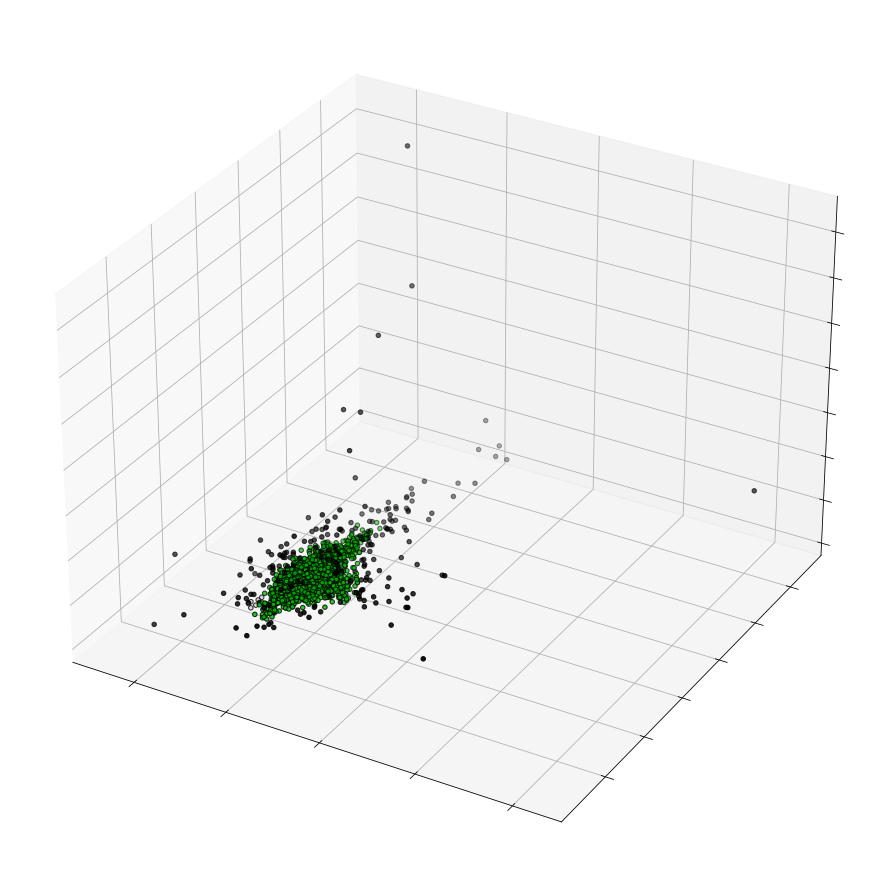

In [244]:
# y = np.choose(dbscan_all.labels_, [1, 2, 0]).astype(np.float)
fig3 = plt.figure()
ax4 = plt.axes(projection='3d')
ax4.scatter(X_scaled_all[:, 0], X_scaled_all[:, 1], X_scaled_all[:, 2], c=dbscan_all.labels_, cmap=plt.cm.nipy_spectral,
           edgecolor='k')
ax4.w_xaxis.set_ticklabels([])
ax4.w_yaxis.set_ticklabels([])
ax4.w_zaxis.set_ticklabels([])

plt.show()
# ax4.scatter(X_scaled_all[dbscan3.labels_==0, 0],X_scaled_all[dbscan3.labels_==0, 1],X_scaled_all[dbscan3.labels_==0, 2],alpha=1,c="red")
# # ax4.scatter(X_scaled_all[dbscan3.labels_==-1, 0],X_scaled_all[dbscan3.labels_==-1, 1],X_scaled_all[dbscan3.labels_==-1, 2],alpha=1,c="green")
# ax4.scatter(X_scaled_all[dbscan3.labels_==1, 0],X_scaled_all[dbscan3.labels_==1, 1],X_scaled_all[dbscan3.labels_==1, 2],alpha=1,c="blue")
# ax4.scatter(X_scaled_all[dbscan3.labels_==2, 0],X_scaled_all[dbscan3.labels_==2, 1],X_scaled_all[dbscan3.labels_==2, 2],alpha=1,c="yellow")
# ax4.scatter(X_scaled_all[dbscan3.labels_==3, 0],X_scaled_all[dbscan3.labels_==3, 1],X_scaled_all[dbscan3.labels_==3, 2],alpha=1,c="purple")
# ax4.scatter(X_scaled_all[dbscan3.labels_==4, 0],X_scaled_all[dbscan3.labels_==4, 1],X_scaled_all[dbscan3.labels_==4, 2],alpha=1,c="orange")
# ax4.scatter(X_scaled_all[dbscan3.labels_==5, 0],X_scaled_all[dbscan3.labels_==5, 1],X_scaled_all[dbscan3.labels_==5, 2],alpha=1,c="green")
# plt.show()

In [246]:
#將分群結果插入dataFrame
financial_ratio_nona.shape
financial_ratio_nona.insert(9,"label_1",dbscan0.labels_)
financial_ratio_nona.insert(10,"label_2",dbscan3.labels_)
financial_ratio_nona.insert(11,"label_all",dbscan_all.labels_)
financial_ratio_nona

,stock_code,data_date,revenue_growth_rate,net_profit_rate,operating_gross_rate,roe_rate,roa_rate,debt_rate,debt_rate_change,label_1,label_2,label_all
1,2303,20162,-2.67,4.27,22.39,0.70,0.51,40.29,0.19,0,0,0
2,2303,20163,8.05,4.60,21.75,0.78,0.59,41.59,0.03,0,0,0
3,2303,20164,13.17,1.17,22.87,0.20,0.19,43.43,0.04,0,0,0
4,2303,20171,8.76,4.00,19.85,0.69,0.60,42.89,-0.01,0,0,0
5,2303,20172,1.46,3.94,17.95,0.68,0.49,44.74,0.04,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3471,8299,20202,10.95,10.91,24.76,4.01,2.97,27.74,0.08,0,0,0
3472,8299,20203,-3.71,15.41,22.61,6.07,4.61,23.66,-0.15,0,0,0
3473,8299,20204,-2.52,29.47,23.05,11.76,8.79,26.09,0.10,0,0,0
3474,8299,20211,0.17,13.09,29.71,4.71,3.41,29.32,0.12,0,0,0


In [247]:
#以營收成長率、淨利率、毛利率分群 label 為 1 者
financial_ratio_nona.loc[financial_ratio_nona.label_1 > 0]  #營收成長率、淨利率、毛利率

,stock_code,data_date,revenue_growth_rate,net_profit_rate,operating_gross_rate,roe_rate,roa_rate,debt_rate,debt_rate_change,label_1,label_2,label_all
854,3228,20203,114.93,17.92,83.35,4.01,3.02,30.51,0.12,1,0,0
855,3228,20204,101.20,46.34,86.82,15.13,11.21,29.53,-0.03,1,-1,-1
856,3228,20211,147.70,50.05,88.46,17.53,12.46,28.60,-0.03,1,-1,-1
1145,3529,20162,-0.11,37.94,100.00,6.13,4.79,31.26,1.64,1,-1,-1
1146,3529,20163,22.85,42.12,100.00,7.23,6.38,12.67,-0.59,1,-1,1
1147,3529,20164,1.78,43.22,100.00,7.08,6.25,12.49,-0.01,1,1,0
1148,3529,20171,5.44,44.89,100.00,7.56,6.65,11.59,-0.07,1,1,0
1149,3529,20172,18.64,40.82,100.00,7.40,5.72,31.62,1.73,1,-1,-1
1150,3529,20173,24.26,50.48,100.00,10.04,8.67,14.70,-0.54,1,-1,-1
1151,3529,20174,5.11,36.56,100.00,5.90,5.12,13.99,-0.05,1,1,0


In [248]:
print(financial_ratio_nona.loc[financial_ratio_nona.label_1 > 0].shape)

(55, 12)


In [249]:
#以毛利率、負債變動率、ROA分群 label 為 1 者
financial_ratio_nona.loc[financial_ratio_nona.label_2 > 0] #毛利率、負債變動率、ROA

,stock_code,data_date,revenue_growth_rate,net_profit_rate,operating_gross_rate,roe_rate,roa_rate,debt_rate,debt_rate_change,label_1,label_2,label_all
1147,3529,20164,1.78,43.22,100.00,7.08,6.25,12.49,-0.01,1,1,0
1148,3529,20171,5.44,44.89,100.00,7.56,6.65,11.59,-0.07,1,1,0
1151,3529,20174,5.11,36.56,100.00,5.90,5.12,13.99,-0.05,1,1,0
1152,3529,20181,11.04,45.06,100.00,7.82,6.74,13.44,-0.04,1,1,0
1155,3529,20184,26.37,40.22,100.00,8.61,7.26,17.61,0.09,1,1,-1
1156,3529,20191,5.50,44.84,100.00,9.72,8.04,16.94,-0.04,1,1,0
1159,3529,20194,-11.03,35.83,100.00,7.55,6.27,16.29,-0.08,1,1,0
1160,3529,20201,5.16,42.55,100.00,9.87,8.22,17.16,0.05,1,1,0
1163,3529,20204,37.24,38.69,100.00,10.37,8.52,19.05,-0.02,1,1,-1
1164,3529,20211,43.64,48.84,100.00,13.53,10.99,18.45,-0.03,1,1,-1


In [250]:
financial_ratio_nona.loc[financial_ratio_nona.label_2 > 0].shape

(33, 12)

In [251]:
#以營收成長率, 稅後淨利率, 營業毛利率, 股東權益報酬率, 資產報酬率分群, 負債變動率 label 大於 1 者
financial_ratio_nona.loc[financial_ratio_nona.label_all > 0]  

,stock_code,data_date,revenue_growth_rate,net_profit_rate,operating_gross_rate,roe_rate,roa_rate,debt_rate,debt_rate_change,label_1,label_2,label_all
1146,3529,20163,22.85,42.12,100.00,7.23,6.38,12.67,-0.59,1,-1,1
1154,3529,20183,2.29,42.87,100.00,8.70,7.39,16.16,-0.51,1,-1,1
1158,3529,20193,-14.40,35.70,100.00,7.27,5.99,17.71,-0.55,1,-1,1
1261,3555,20174,-47.47,90.31,8.04,11.31,10.67,5.07,-0.31,-1,-1,1
1924,5314,20183,-66.99,216.04,-58.89,12.77,10.45,14.94,-0.10,-1,-1,1
2944,6643,20203,0.41,30.26,100.00,5.80,5.16,12.15,-0.53,1,-1,1


In [252]:
financial_ratio_nona.loc[financial_ratio_nona.label_all > 0].shape

(6, 12)